In [1]:
import numpy as np
import pandas as pd
import zipfile         
import os
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns 
import DateTime
import re 
import cpi
import warnings
from cols_to_keep import * #small python file i made just with long list of dates we don't need 
warnings.filterwarnings('ignore')

#pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_columns", 330)

In [5]:
cd /Users/quinnunderriner/Desktop/Work/missing_middle/zillow

/Users/quinnunderriner/Desktop/Work/missing_middle/zillow


From Zillow: the change in low and high tier values for home sales by county (ideally from 2010-2019 if we have it), 10 MSAs above, and also a statewide graph.

In [21]:
#read in data (data from here https://www.zillow.com/research/data/, top input, all home low and high tier time series)
county_low_tier = pd.read_csv("County_zhvi_uc_sfrcondo_tier_0.0_0.33_sm_sa_mon.csv")
county_high_tier = pd.read_csv("County_zhvi_uc_sfrcondo_tier_0.67_1.0_sm_sa_mon.csv")
#filter for california 
county_low_tier = county_low_tier[county_low_tier.StateName == "CA"]
county_high_tier = county_high_tier[county_high_tier.StateName == "CA"]
#make flags for the tiers 
county_low_tier["Tier"] = "Low Tier"
county_high_tier["Tier"] = "High Tier"
#merge data together for all california (run CPI on all of them ?)
county_home_value = pd.concat([county_low_tier,county_high_tier])
#filter out columns with price data before 2010 
county_home_value = county_home_value[cols_to_keep]

In [72]:
county_home_value.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,Tier
0,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,37,263084.00,261803.00,261669.00,262646.00,265429.00,264874.00,264153.00,261965.00,260661.00,259292.00,257324.00,256081.00,255280.00,255283.00,253976.00,252568.00,249440.00,249031.00,248382.00,248020.00,246518.00,244816.00,244639.00,243768.00,243426.00,242731.00,242458.00,242471.00,243422.00,244599.00,246029.00,247391.00,249476.00,252823.00,255708.00,259821.00,262856.00,268065.00,273317.00,279928.00,285371.00,290950.00,296468.00,303245.00,309059.00,313195.00,316555.00,318715.00,321957.00,322848.00,324304.00,324489.00,325798.00,326537.00,328200.00,328512.00,329187.00,330025.00,332169.00,334331.00,337119.00,340158.00,343190.00,344393.00,346320.00,348136.00,349919.00,351609.00,353468.00,356097.00,358513.00,361973.00,363964.00,366332.00,367670.00,371408.00,373882.00,376736.00,378184.00,380761.00,383971.00,387435.00,389347.00,390630.00,392968.00,395200.00,397803.00,399542.00,402649.00,405339.00,408747.00,411660.00,414244.00,416306.00,420058.00,423788.00,427312.00,430792.00,434579.00,437825.00,440405.00,442911.00,445344.00,446384.00,446811.00,447286.00,447785.00,447407.00,447019.00,445058.00,443275.00,443085.00,446007.00,449875.00,450826.00,450957.00,451307.00,453413.00,454833.00,457221.00,459890.00,464042.00,468184.00,471782.00,473370.00,474698.00,478664.00,484498.00,490982.00,496634.00,Low Tier
4,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,6,73,257990.00,258346.00,259400.00,261759.00,262304.00,262968.00,261864.00,262001.00,260699.00,258825.00,256362.00,255029.00,253464.00,252220.00,250011.00,248833.00,247684.00,247058.00,246013.00,244075.00,242534.00,241628.00,241433.00,240056.00,239974.00,240096.00,241185.00,241030.00,242084.00,243586.00,245396.00,247652.00,250435.00,253977.00,257184.00,262222.00,265964.00,269483.00,273779.00,279554.00,285494.00,291464.00,297665.00,304588.00,308757.00,311766.00,313949.00,316183.00,320019.00,324714.00,325565.00,325268.00,323687.00,324131.00,325257.00,324300.00,325386.00,326217.00,329290.00,330305.00,329641.00,329501.00,333320.00,336683.00,340100.00,340716.00,341705.00,343401.00,345552.00,348165.00,350253.00,353625.00,358905.00,360993.00,360675.00,361025.00,362539.00,365644.00,366958.00,370306.00,373154.00,376491.00,378650.00,380607.00,380543.00,382833.00,386424.00,391079.00,395432.00,398269.00,400947.00,402073.00,404395.00,406863.00,409026.00,411561.00,416179.00,420705.00,423329.00,423065.00,422661.00,423803.00,4

In [37]:
county_home_value_melt = county_home_value.drop(columns=["RegionID","SizeRank",
                                                     "RegionName","RegionType","StateName","State","StateCodeFIPS",
                                                     "MunicipalCodeFIPS"])

In [50]:
county_home_value_melt = county_home_value_melt.melt(["Tier","Metro"])

In [ ]:
df_melt = county_home_value_melt.melt(["County_Name","year",'Metro_Area_Name'])

In [55]:
county_home_value_melt = county_home_value_melt.rename(columns={"variable":"Date","value":"House Cost"})

In [56]:
county_home_value_melt['Date'] = pd.to_datetime(county_home_value_melt['Date'])

In [57]:
county_home_value_melt.head()

,Tier,Metro,Date,House Cost
0,Low Tier,Los Angeles-Long Beach-Anaheim,2010-01-31,263084.00
1,Low Tier,San Diego-Carlsbad,2010-01-31,257990.00
2,Low Tier,Los Angeles-Long Beach-Anaheim,2010-01-31,362974.00
3,Low Tier,Riverside-San Bernardino-Ontario,2010-01-31,157277.00
4,Low Tier,Riverside-San Bernardino-Ontario,2010-01-31,117765.00


In [93]:
def adjust_for_CPI(date,house_cost):
    if date.year == 2010:
        return cpi.inflate(house_cost, 2010)
    if date.year == 2011:
        return cpi.inflate(house_cost, 2011)
    if date.year == 2012:
        return cpi.inflate(house_cost, 2012)
    if date.year == 2013:
        return cpi.inflate(house_cost, 2013)
    if date.year == 2014:
        return cpi.inflate(house_cost, 2014)
    if date.year == 2015:
        return cpi.inflate(house_cost, 2015)
    if date.year == 2016:
        return cpi.inflate(house_cost, 2016)
    if date.year == 2017:
        return cpi.inflate(house_cost, 2017)
    if date.year == 2018:
        return cpi.inflate(house_cost, 2018)
    if date.year == 2019:
        return cpi.inflate(house_cost, 2019)
    if date.year == 2020:
        return house_cost

In [ ]:
df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)


In [101]:
county_home_value_melt['House_Cost_(2019)'] = county_home_value_melt[["Date","House Cost"]].apply(lambda x: adjust_for_CPI(*x), axis=1)

### Graph all California 

Text(0.5, 1.0, 'Changes in California Housing Cost')

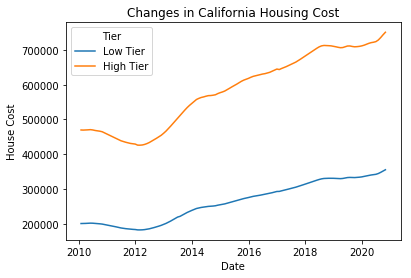

In [114]:
sns.lineplot(data=county_home_value_melt, x="Date", y="House Cost",hue="Tier",ci=None).set_title('Changes in California Housing Cost')


Text(0.5, 1.0, 'Changes in California Housing Cost (2020$))')

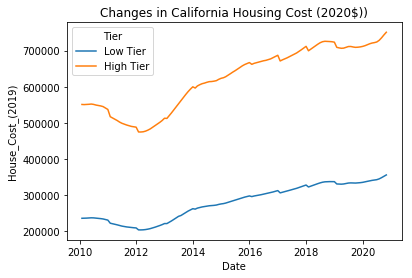

In [115]:
sns.lineplot(data=county_home_value_melt, x="Date", y="House_Cost_(2019)",hue="Tier",ci=None).set_title('Changes in California Housing Cost (2020$))')


###  Graph top 10 MSA 

In [108]:
#load in top 10 msas
msa = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/msa.csv")
msa = msa[["MSA_NAME","COUNTIES"]]
top_10_msa = ['Riverside-San Bernardino-Ontario','San Jose-Sunnyvale-Santa Clara',
              'San Francisco-Redwood City-South San Francisco','Oakland-Hayward-Berkeley',
              'Los Angeles-Long Beach-Glendale','Anaheim-Santa Ana-Irvine','San Diego-Carlsbad',
               'Sacramento--Roseville--Arden-Arcade','Fresno','Oxnard-Thousand Oaks-Ventura']
msa = msa[msa.MSA_NAME.isin(top_10_msa)]
#need to expand mapping 
msa = msa.drop('COUNTIES', axis=1).join(
  msa['COUNTIES'].str.split(',', expand=True).stack()
    .reset_index(level=1,drop=True).rename('COUNTIES'))
msa['COUNTIES'] = msa['COUNTIES'] + " County" 
msa = msa.rename(columns={"COUNTIES":"County_Name","MSA_NAME":"Metro"})#rename for clean merge

# merge and subset data to just contain top 10 MSAs 
top_10_msa = msa.merge(county_home_value_melt, on="Metro",how="left")

Text(0.5, 1.0, 'Changes in Housing Cost California top 10 MSAs ($2020))')

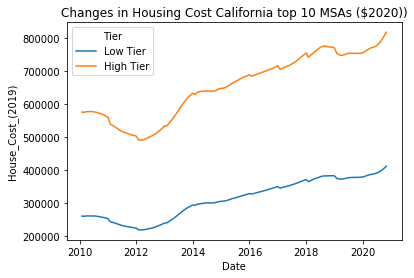

In [116]:
top_10_msa


sns.lineplot(data=top_10_msa, x="Date", y="House_Cost_(2019)",hue="Tier",ci=None).set_title('Changes in Housing Cost California top 10 MSAs ($2020))')
